# Regression of Used Car Prices

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import category_encoders as ce

from catboost import CatBoostRegressor
from catboost import Pool

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


import shap


In [124]:
data = pd.read_csv('train.csv')
data.head()


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


Рассмотрим столбцы:
1. id - совпадает с индексом нашей строки
2. brand - марка автомобиля
3. model - модель автомобиля
4. model_year - год выпуска
5. milage - пробег
6. fuel_type - тип топлива
7. engine - двигатель(мощность + объём + кол-во цилиндров + тип двигателя + тип топлива)
8. transmission - тип коробки передач
9. ext_col - цвет автомобиля
10. int_col - цвет салона
11. accident - информация о ДТП
12. clean_title - статус юридической чистоты автомобиля 
13. price - цена автомобиля

# Exploratiry Data Analysis

In [126]:
# Удалим столбец id
data = data.drop(columns = ['id'])
data.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [127]:
# Создадим список категориальных фичей
categorical_columns = data.select_dtypes(include=['object','category']).columns.to_list()
# Создадим список числовых фичей
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.difference(['price','id']).to_list()
# Создадим target с ценами автомобилей
target = 'price'

print("Categorical_columns:")
print(categorical_columns)
print("Numerical_columns:")
print(numerical_columns)

print()

Categorical_columns:
['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Numerical_columns:
['milage', 'model_year']



# Data processing

In [128]:
# Посмотрим,сколько пропусков у нас в каждом признаке и какой процент от всех данных составляют пропуски
total_rows = len(data)
missing_counts = data.isnull().sum()
missing_percentage = (missing_counts / total_rows) * 100

missing_data = pd.DataFrame({
    'Feature': missing_counts.index,  # Название признаков
    'Missing Count': missing_counts.values,  # Количество пропусков
    'Missing Percentage': missing_percentage.values  # Процент пропусков
})

# Сортировка по убыванию количества пропусков
missing_data = missing_data.sort_values(by=['Missing Count', 'Missing Percentage'], ascending=False)
print(missing_data)

         Feature  Missing Count  Missing Percentage
10   clean_title          21419           11.360876
4      fuel_type           5083            2.696080
9       accident           2452            1.300568
0          brand              0            0.000000
1          model              0            0.000000
2     model_year              0            0.000000
3         milage              0            0.000000
5         engine              0            0.000000
6   transmission              0            0.000000
7        ext_col              0            0.000000
8        int_col              0            0.000000
11         price              0            0.000000


У нас пропуски в столбцах: clean_title(11%),fuel_type(2.7%) и accident(1.3%):
1. Пропуски в clean_title логичнее всего заполнить NO - то есть у автомобиля нет юридической чистоты,раз это не указано.
2. Пропущенные значения в fuel_type можем достать из столбца engine.
3. Пропуски в accident можно заполнить At least 1 accident or damage reported,раз не указано None reported,значит скорее всего были ДТП.

In [129]:
data['accident'] = data['accident'].fillna('At least 1 accident or damage reported')
data['clean_title'] = data['clean_title'].fillna('NO')

In [130]:
fuel_type_counts = data['fuel_type'].sort_values()

In [131]:
# Создадим функцию,которая в описании двигателя находит тип топлива
def findFuel(engine):
    mas = engine.split()
    for type in list(fuel_type_counts.index):
        if type in mas:
            return type
    return "unknown"

In [132]:
'''
data['fuel_type'] = data.apply(
    lambda row: findFuel(row['engine']) if pd.isna(row['fuel_type']) else row['fuel_type'], axis=1
)
'''

"\ndata['fuel_type'] = data.apply(\n    lambda row: findFuel(row['engine']) if pd.isna(row['fuel_type']) else row['fuel_type'], axis=1\n)\n"

In [133]:
data['fuel_type'] = data['fuel_type'].fillna('electric')

In [134]:
# Проверим,что заполнили все пропущенные значения
missing_counts = data.isna().sum().sum()
print(missing_counts)

0


Заполнили все пропуски в датасете.

In [135]:
# Преобразуем тип категориальных признаков в category
for feature in categorical_columns:
    data[feature] = data[feature].astype('category')


In [136]:
# Разделим наши данные на тренировочную и тестовую выборку
X = data.drop('price',axis = 1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [137]:
# Целевая кодировка категориальных признаков
target_encoder = ce.TargetEncoder(cols=categorical_columns)

In [138]:
# Обучаем кодировщик на тренировочных данных и применяем его
X_train_encoded = target_encoder.fit_transform(X_train, y_train)
X_test_encoded = target_encoder.transform(X_test)

In [139]:
scaler = StandardScaler()
scaler.fit(X_train_encoded)
X_train_encoded = scaler.transform(X_train_encoded)
X_test_encoded = scaler.transform(X_test_encoded)

/Users/vovatkachev/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


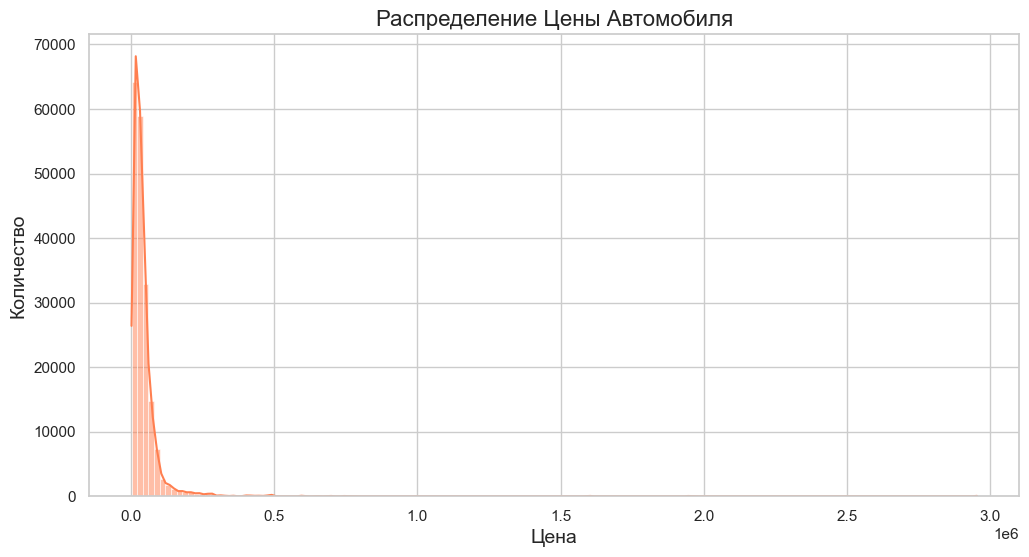

In [140]:
plt.figure(figsize=(12, 6))
sns.histplot(y, bins=150, kde=True, color='coral')
plt.title('Распределение Цены Автомобиля', fontsize=16)
plt.xlabel('Цена', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.show()

# Catboost

In [141]:
params = {
    'loss_function' : 'RMSE',
    'eval_metric' : 'RMSE',
    'iterations' : 1000,
    'random_seed' : 42,
    'learning_rate' : 0.03,
    'l2_leaf_reg' : 3,
    'random_strength' : 1,
    'bagging_temperature' : 1,
    'leaf_estimation_method' : 'Newton',
    'one_hot_max_size' : 2,

}

In [142]:
cb_model = CatBoostRegressor(**params)
cb_model.fit(X_train_encoded,y_train,verbose=0)


In [143]:
# Предсказания для Catboost
cb_predictions = cb_model.predict(X_test_encoded)
cb_rmse = np.sqrt(mean_squared_error(y_test, cb_predictions))
print(f'RMSE для Catboost: {cb_rmse}')

RMSE для Catboost: 68262.6935940098


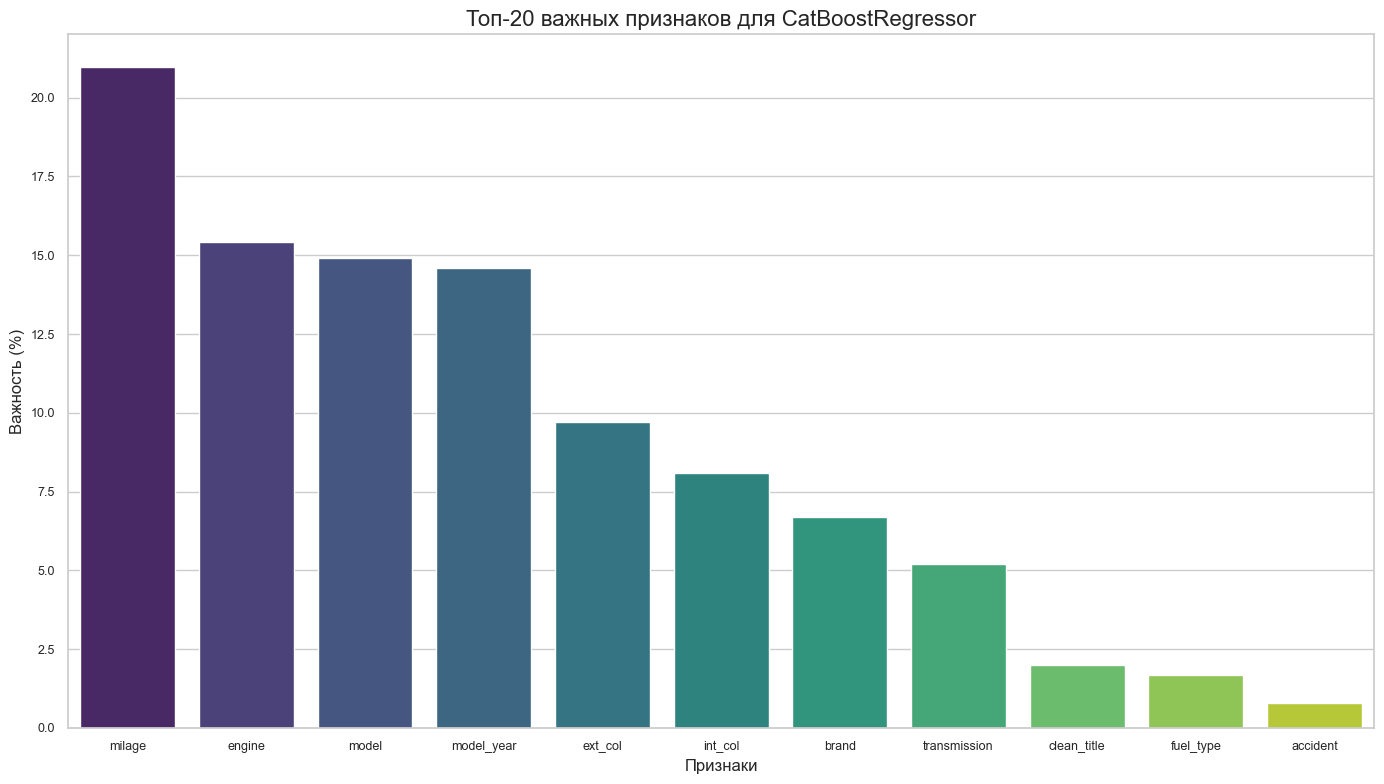

In [144]:
# Получение важности признаков
feature_importances = cb_model.get_feature_importance()

# Преобразование важности в проценты
importance_percentage = 100 * (feature_importances / feature_importances.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)

sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')

# Настройка заголовков и меток осей
plt.title("Топ-20 важных признаков для CatBoostRegressor", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)

# Поворот меток оси X на 90 градусов для лучшей читаемости
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)

# Автоматическое выравнивание элементов графика
plt.tight_layout()

# Отображение графика
plt.show()

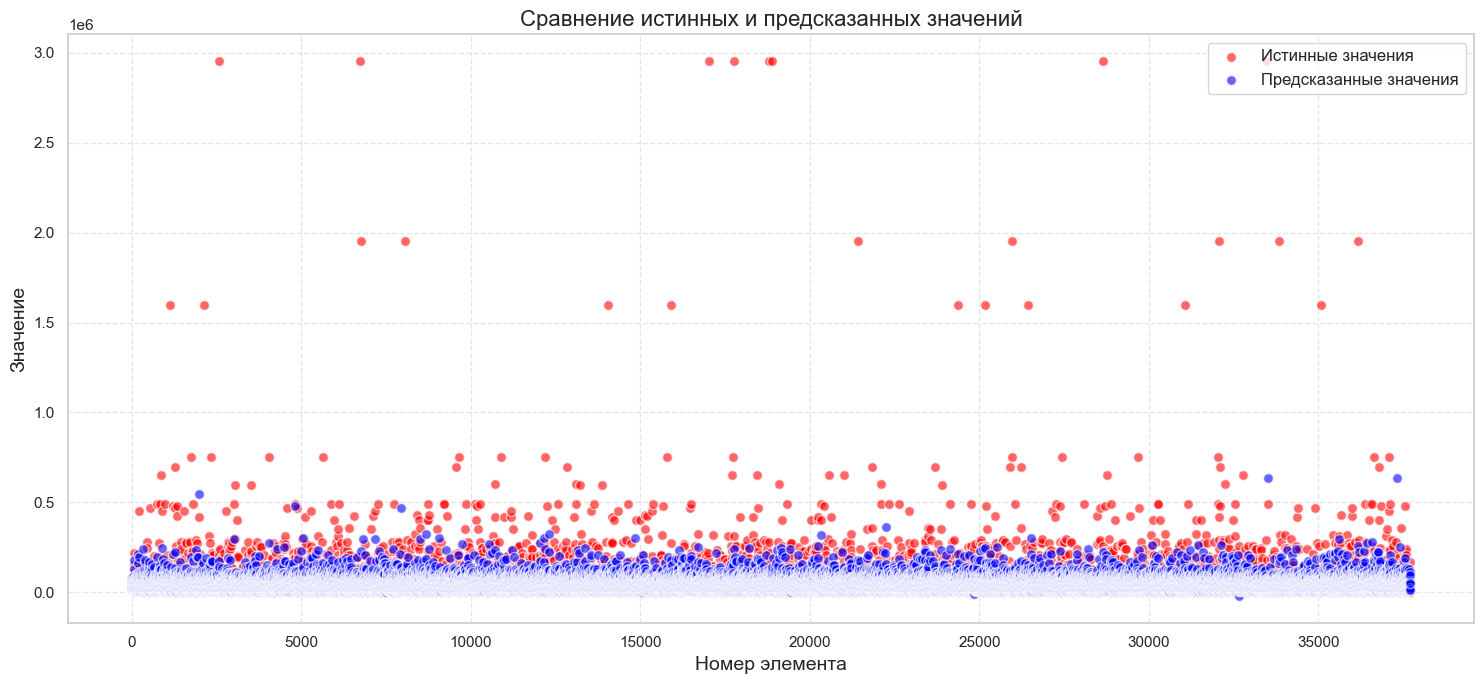

In [145]:
def plot_y_test_vs_y_pred(y_test, y_pred, title='True vs Predicted Values'):
    """
    Строит график с истинными значениями (y_test) и предсказанными значениями (y_pred).

    Параметры:
    - y_test: array-like или pandas Series, истинные значения.
    - y_pred: array-like или pandas Series, предсказанные значения.
    - title: str, заголовок графика.
    """
    # Преобразование pandas Series в numpy массивы, если необходимо
    if isinstance(y_test, pd.Series):
        y_test = y_test.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values

    # Проверка, что длины y_test и y_pred совпадают
    if len(y_test) != len(y_pred):
        raise ValueError("Длины y_test и y_pred должны совпадать.")

    # Создание массива индексов для оси X
    x = np.arange(len(y_test))

    plt.figure(figsize=(15, 7))

    # Построение истинных значений (красные точки)
    plt.scatter(x, y_test, color='red', label='Истинные значения', alpha=0.6, edgecolors='w', s=50)

    # Построение предсказанных значений (синие точки)
    plt.scatter(x, y_pred, color='blue', label='Предсказанные значения', alpha=0.6, edgecolors='w', s=50)

    # Добавление линии тренда для истинных и предсказанных значений (опционально)
    # plt.plot(x, y_test, color='red', linestyle='-', alpha=0.5)
    # plt.plot(x, y_pred, color='blue', linestyle='--', alpha=0.5)

    # Добавление меток и заголовка
    plt.xlabel('Номер элемента', fontsize=14)
    plt.ylabel('Значение', fontsize=14)
    plt.title(title, fontsize=16)

    # Добавление легенды
    plt.legend(fontsize=12)

    # Добавление сетки для лучшей читаемости
    plt.grid(True, linestyle='--', alpha=0.5)

    # Опционально: Ограничение диапазона по оси X, если слишком много точек
    # plt.xlim(0, len(y_test))

    # Автоматическое расположение элементов для предотвращения наложения
    plt.tight_layout()

    # Отображение графика
    plt.show()

# Пример использования:
# Предположим, что y_test и y_pred уже определены после обучения модели



# Вызов функции для построения графика
plot_y_test_vs_y_pred(y_test, cb_predictions, title='Сравнение истинных и предсказанных значений')